# LiDAR analysis

## Introduction

This notebook shows how to find, read, subset and inspect **lvis level-2a** (l2a) granules over field sites.

#### Note:

The notebook was done on the [BioSCape's Cloud Environment](https://cloud.bioscape.io/) which provides direct access to data and computational resources. Access to the cloud environment can be requested at bioscape.io/data.

### Import python modules

In [ ]:
# Import python modules
from glob import glob
import numpy as np
import pandas as pd
import earthaccess
import geopandas as gpd
import requests as re
import folium
import s3fs
import h5py
from os import path
from pathlib import Path
from datetime import datetime
from shapely.geometry import Polygon, MultiPolygon, box
import matplotlib.pyplot as plt
import linecache
import contextily as cx
import dask.dataframe as dd
from shapely.ops import orient, unary_union
from shapely.validation import make_valid
from harmony import BBox,Client, Collection, Request, LinkType

In [30]:
# Esri background basemap for maps
xyz = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
attr = "ESRI"

In [31]:
# List the LVIS folders at the BioSCape SMCE
s3 = s3fs.S3FileSystem(anon=False)
lvis = s3.ls('bioscape-data/LVIS')
lvis

['bioscape-data/LVIS/L1B', 'bioscape-data/LVIS/L2']

### Read the site polygons and show them on a small folium map

We read the geojson files that define each field plot/site, unify them into a single geopandas geodataframe (`all_sites`) and compute a center for initial folium map view.

Notes for readers with no GIS background:
- A geojson contains polygon geometries; geopandas reads them and understands coordinate reference systems (crs)
- Folium shows the polygons on a slippy map in the notebook / in html

In [32]:
# Read all sites and tag them
files = {
    "Site1": "data/field_plots/Site1.geojson",
    "Site2": "data/field_plots/Site2.geojson",
    "Site3": "data/field_plots/Site3.geojson",
    "Site4": "data/field_plots/Site4.geojson",
    "Site5": "data/field_plots/Site5.geojson",
    "Site6": "data/field_plots/Site6.geojson",
    "Site7": "data/field_plots/Site7.geojson",
}

gdfs = []
for name, path in files.items():
    gdf = gpd.read_file(path)
    gdf["site"] = name
    # If CRS is missing or not geographic, bring everything to EPSG:4326 for Folium
    if gdf.crs is None:
        # If you really know the source CRS, set it explicitly before converting.
        # gdf = gdf.set_crs("EPSG:XXXX")
        pass
    gdfs.append(gdf)

all_sites = pd.concat(gdfs, ignore_index=True)
all_sites = all_sites.to_crs("EPSG:4326")  # safe even if already 4326

centroid = all_sites.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=12, control_scale=True, tiles=None)

try:
    folium.TileLayer(tiles=xyz, attr=attr, name="Custom").add_to(m)
except NameError:
    folium.TileLayer("OpenStreetMap", name="OSM").add_to(m)
    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri, Maxar, Earthstar Geographics",
        name="ESRI World Imagery"
    ).add_to(m)

all_sites.explore(m=m,
    column="site",
    legend=True,
    name="All Sites",
    tooltip=["site"],
    style_kwds={"fill": False, "weight": 2}
)

Skipping field center: unsupported OGR type: 3
/tmp/ipykernel_440/4276048821.py:26: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = all_sites.unary_union.centroid


### Build a single query polygon and search for LVIS L2A granules

What this code does is dissolve the site polygons into a single polygon and simplify it for the earthaccess query. It then queries the LVIS l2a collection (by doi) for a given date range and polygon

notes:
- Earthaccess allows convenient programmatic queries against NSIDC's CMR. you may need to login (ea.login()).
- The polygon is simplified so the query URL does not exceed web limits

In [6]:
# Build a single, simple polygon for querying
roi = unary_union(all_sites.geometry)          # dissolve to one geometry
roi = roi.convex_hull                          # single polygon is easiest for CMR
roi = orient(roi, sign=1.0)                    # counter-clockwise (not mandatory but tidy)
roi = roi.simplify(0.005, preserve_topology=True)  # reduce vertices to stay under URL limits

# Extract a closed lon/lat ring for CMR
xs, ys = roi.exterior.xy                       # Shapely returns a closed ring already
coords = list(zip(xs, ys))
if coords[0] != coords[-1]:                    # belt-and-braces closure
    coords.append(coords[0])

# Query LVIS L2A (by DOI) over your polygon and temporal window
import earthaccess as ea
# ea.login()  # if needed
l2_poly = ea.search_data(
    doi="10.5067/VP7J20HJQISD",
    temporal=("2023-10-01", "2023-11-30"),
    polygon=coords,
    count=-1
)
print(f"Granules found: {len(l2_poly)}")

Granules found: 16
Granules found: 16


### Convert the earthaccess results to a geopandas dataframe and view footprints

We convert the UMM geometry returned by earthaccess into shapely polygons then produce a geopandas dataframe with a `geometry` column so we can visualise footprints.

In [33]:
def convert_umm_geometry(gpoly):
    """converts UMM geometry to multipolygons"""
    multipolygons = []
    for gl in gpoly:
        ltln = gl["Boundary"]["Points"]
        points = [(p["Longitude"], p["Latitude"]) for p in ltln]
        multipolygons.append(Polygon(points))
    return MultiPolygon(multipolygons)

def convert_list_gdf(datag):
    """converts List[] to geopandas dataframe"""
    # Create pandas dataframe from json
    df = pd.json_normalize([vars(granule)['render_dict'] for granule in datag])
    # Keep only last string of the column names
    df.columns=df.columns.str.split('.').str[-1]
    # Convert polygons to multipolygonal geometry
    df["geometry"] = df["GPolygons"].apply(convert_umm_geometry)
    # Return geopandas dataframe
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

gdf = convert_list_gdf(l2_poly)
m = gdf[['BeginningDateTime','geometry']].explore(tiles=xyz, attr=attr, 
                                              style_kwds={'fillOpacity':0.1})
m

The footprints plotted here are the areas covered by each LVIS granule. We use them to decide which granules overlap our sites and which files to read. 


Next we inspect data links for a particular granule. This returns remote urls:

**_The data_links for a granule show the files (.txt) that can be downloaded or accessed on S3._**

In [34]:
l2_poly[1].data_links()

['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/LVIS/LVISF2/1/2023/10/28/LVISF2_BioSCape2023_1028_R2404_051113.TXT']

### Build a list of bioscape s3 file paths for the overlapping granules

For each granule that overlaps our site polygon, we find the matching file in the bioscape s3 bucket (this repository stores lvis l2 text files).

In [37]:
# Replace the overlapping granule names with the one from BioSCape S3 bucket.

lvis_f = []
for s in gdf.index:
    lvis_f.append(path.join('s3://bioscape-data/LVIS/L2/', 
                            path.basename(l2_poly[s].data_links()[0])))
lvis_f

['s3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_050431.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_051113.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_051210.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1028_R2404_052128.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_036051.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_037033.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_037808.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_038739.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039532.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_039619.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_040572.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_041386.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_1029_R2404_044604.TXT',
 's3://bioscape-data/LVIS/L2/LVISF2_BioSCape2023_11

### Helper to detect header rows and read LVIS text file from s3

LVIS l2 text files have a header block starting with '#' lines that list column names. The helper finds how many header lines to skip and returns the column names.

In [38]:
# Parse helper
def get_line_number(filename):
    """find number of header rows in LVIS L2A"""
    count = 0
    with s3.open(filename, 'rb') as f:
        for line in f:
            if line.startswith(b'#'):
                count = count + 1
                columns = line[1:].split()
            else:
                return count, columns

We then create a 100 m buffer around each field site then read the text file into a pandas dataframe, create a geometry column, and spatially subset to our site buffer.

In [39]:
# Create a buffer around fire sites
poly_utm = all_sites.to_crs("EPSG:22234") # UTM 34 S
poly_utm.geometry = poly_utm.geometry.buffer(100) # 100m buffer
poly_wgs_gdf = poly_utm.to_crs("EPSG:4326")

# Read the LVIS L2A files
lvis_l2a = []
for f in lvis_f:
    h_no, col_names = get_line_number(f)
    temp_df = pd.read_csv(f, skiprows=h_no, header=None, 
                          engine='python', sep=r'\s+')
    temp_df.columns =  [x.decode() for x in col_names]
    temp_gdf = gpd.GeoDataFrame(temp_df, 
                                geometry=gpd.points_from_xy(temp_df.GLON, 
                                                            temp_df.GLAT),
                                crs="EPSG:4326")
    temp_sub = gpd.sjoin(temp_gdf, poly_wgs_gdf, predicate='within')
    if not temp_sub.empty:
        print(f'Subsetting {path.basename(f)}')
        lvis_l2a.append(temp_sub)
lvis_l2a_gdf = pd.concat(lvis_l2a)

Subsetting LVISF2_BioSCape2023_1028_R2404_051113.TXT
Subsetting LVISF2_BioSCape2023_1028_R2404_052128.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_037033.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_037808.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_040572.TXT
Subsetting LVISF2_BioSCape2023_1029_R2404_041386.TXT
Subsetting LVISF2_BioSCape2023_1113_R2404_034819.TXT
Subsetting LVISF2_BioSCape2023_1113_R2404_039379.TXT


`lvis_l2a_gdf` now contains all LVIS returns (points) that fall within the 100 m buffered sites. These points include columns such as RH100 (relative height at 100%), GLON/GLAT (longitude/latitude), and other LVIS-derived metrics."

### Height of top canopy

The code cell below builds a clipped set of LiDAR shots (points) and approximate LiDAR footprints (buffers) restricted to our site polygons. We compute percentiles of the relative height metric (RH100) and render an interactive folium map showing clipped shots coloured by RH100.

In [40]:
# Approximate LVIS footprint diameter (metres)
foot_diameter_m = 25.0
foot_radius_m   = foot_diameter_m / 2.0
utm_epsg        = 32734  # UTM 34S (metres); use 32735 if your sites are further east

# -----------
# Build a reliable polygon mask in metres
sites_utm = all_sites[["site", "geometry"]].to_crs(utm_epsg).copy()
# Fix minor invalidities; keeps topology
sites_utm["geometry"] = sites_utm.buffer(0)

# One geometry per site so we can re-assign site names cleanly
sites_diss = sites_utm.dissolve(by="site")
# A union mask to clip the footprint buffers (so circles don't spill outside)
mask_union = gpd.GeoDataFrame(geometry=[sites_diss.unary_union], crs=sites_diss.crs)

# -----------
# Drop missing RH100 before joins; project to metres
pts_utm = lvis_l2a_gdf[["RH100", "geometry"]].dropna(subset=["RH100"]).to_crs(utm_epsg)

# Spatial join with intersects keeps boundary points; index_right gives the site label
pts_clip_utm = gpd.sjoin(pts_utm, sites_diss, how="inner", predicate="intersects")
pts_clip_utm = pts_clip_utm.rename(columns={"index_right": "site"})[["site", "RH100", "geometry"]]

# -----------
# Footprints from the clipped shots, then clip the buffers
buf_utm = pts_clip_utm[["site", "geometry"]].copy()
buf_utm["geometry"] = buf_utm.buffer(foot_radius_m)      # circles in metres
buf_clip_utm = gpd.clip(buf_utm, mask_union)              # trim to sites

# -----------
# Hop back to WGS84 for Folium rendering
pts_web  = pts_clip_utm.to_crs(4326)
buf_web  = buf_clip_utm.to_crs(4326)
sites_web = sites_utm.to_crs(4326)

# -----------
# Map: clipped RH100 shots + site polygons + optional footprints
vmin, vmax = np.nanpercentile(pts_web["RH100"], [2, 98])

m = pts_web.explore(
    column="RH100",
    cmap="YlGn",
    vmin=float(vmin), vmax=float(vmax),
    tiles=xyz, attr=attr,
    alpha=0.6, radius=6,
    legend=True,
    legend_kwds={"position": "bottomright", "caption": "LVIS RH100 (m)"},
    tooltip=["site", "RH100"],
    name="RH100 shots (clipped)"
)

# Site polygons with a categorical legend
sites_web.explore(
    m=m,
    name="Sites (polygons)",
    column="site",
    categorical=True,
    legend=True,
    legend_kwds={"position": "topleft", "caption": "Sites"},
    tooltip=["site"],
    style_kwds={"fill": False, "weight": 2}
)

# Optional: clipped footprints layer (toggleable)
buf_web.explore(
    m=m,
    name=f"LVIS footprints (clipped, ~{int(foot_diameter_m)} m)",
    style_kwds={"fill": False, "color": "red", "weight": 1, "opacity": 0.7},
    tooltip=["site"]
)

folium.LayerControl(position="bottomleft", collapsed=True).add_to(m)
m  # display

/tmp/ipykernel_440/2664574201.py:15: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  mask_union = gpd.GeoDataFrame(geometry=[sites_diss.unary_union], crs=sites_diss.crs)


In [ ]:
# Save clean layers for QGIS
out_gpkg = "data/outputs/lvis_sites_clipped.gpkg"
sites_web[["site", "geometry"]].to_file(out_gpkg, layer="sites", driver="GPKG")
pts_web[["site", "RH100", "geometry"]].to_file(out_gpkg, layer="lvis_shots_clipped", driver="GPKG")
buf_web[["site", "geometry"]].to_file(out_gpkg, layer="lvis_footprints_clipped", driver="GPKG")
m.save("data/outputs/lvis_rh100_sites_clipped.html")
print("Wrote:",
      "\n • data/outputs/lvis_rh100_sites_clipped.html",
      f"\n • {out_gpkg} [layers: sites, lvis_shots_clipped, lvis_footprints_clipped]")

## Relative Height Distribution

The relative height distribution plot of the RH metrics is created to to check if the vegetation height across the percentile of waveform energy indicates the same.

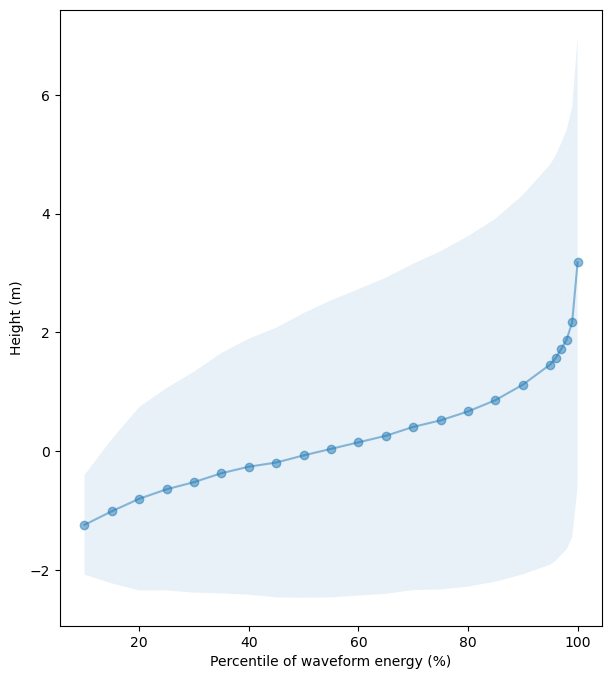

In [14]:
fig, ax = plt.subplots(figsize=(7, 8))
plot_df = lvis_l2a_gdf.sample(frac=0.1, random_state=1).filter(like='RH').drop('CHANNEL_RH', axis=1).T
plot_df.index = plot_df.index.str.strip('RH').astype(int)
std_df = plot_df.std(axis=1)
median_df = plot_df.median(axis=1)
median_df.plot(ax=ax, alpha=0.5, style='o-')
ax.fill_between(plot_df.index, median_df - std_df, median_df + std_df, alpha=0.1)
ax.set_xlabel("Percentile of waveform energy (%)")
ax.set_ylabel("Height (m)")
plt.show()

In [29]:
# Exporting 
lvis_l2a_gdf.geometry.to_file('data/outputs/lvis2_rh_distribution.geojson', driver="GeoJSON")
lvis_l2a_gdf.to_csv('data/outputs/lvis_rh_distribution.csv')

In [41]:
import numpy as np, pandas as pd, geopandas as gpd

# Pick authoritative clipped points:
gdf_points = None
if 'pts_web' in globals():
    gdf_points = pts_web.copy()
else:
    # Fall back: clip raw lvis_l2a_gdf against sites_web polygons
    assert 'lvis_l2a_gdf' in globals(), "Need lvis_l2a_gdf"
    assert 'sites_web' in globals() or 'buf_web' in globals(), "Need sites_web or buf_web polygons"
    base = lvis_l2a_gdf.copy()
    polys = sites_web if 'sites_web' in globals() else buf_web

    # Align CRS
    if base.crs is None:
        raise ValueError("lvis_l2a_gdf has no CRS; set it correctly before clipping.")
    if polys.crs != base.crs:
        polys = polys.to_crs(base.crs)

    # Keep points that fall within site polygons/buffers
    gdf_points = gpd.sjoin(base, polys[['site','geometry']], predicate="within", how="inner")
    # sjoin may create 'index_right'; keep one 'site' column
    if 'site_right' in gdf_points.columns and 'site' in gdf_points.columns:
        gdf_points['site'] = gdf_points['site_right']
        gdf_points = gdf_points.drop(columns=['site_right'])

# Clean site labels to 1..7
def clean_site(x):
    s = str(x).strip()
    for token in ("Site", "site"):
        if s.startswith(token): s = s[len(token):].strip()
    try:
        return int(s)
    except Exception:
        return s

gdf_points = gdf_points.copy()
gdf_points['site_clean'] = gdf_points['site'].apply(clean_site)

# Basic checks
needed = ['RH100']
if not all(c in gdf_points.columns for c in needed):
    raise ValueError(f"Missing columns in points: {needed}")

summary = (gdf_points
           .groupby('site_clean')['RH100']
           .agg(n='count', min='min', q50='median', q75=lambda s: s.quantile(0.75), max='max')
           .sort_index())
print(summary)

# (Optional) spot outliers by site: very tall values compared to the upper quartile
summary['suspect_outlier'] = (summary['max'] > summary['q75'] * 1.8)
print("\nPotential outliers (max >> Q3):\n", summary.loc[summary['suspect_outlier']])

             n   min    q50     q75    max
site_clean                                
1           10  1.79  2.580  2.8800   5.77
2           10  1.87  2.200  3.2200   3.41
3            6  3.07  3.460  3.8225   4.00
4            5  1.42  1.900  4.8100   4.97
5            8  2.13  2.880  3.4400   4.42
6            4  3.74  4.455  4.4900   4.49
7            4  3.60  8.635  9.4400  10.34

Potential outliers (max >> Q3):
              n   min   q50   q75   max  suspect_outlier
site_clean                                             
1           10  1.79  2.58  2.88  5.77             True


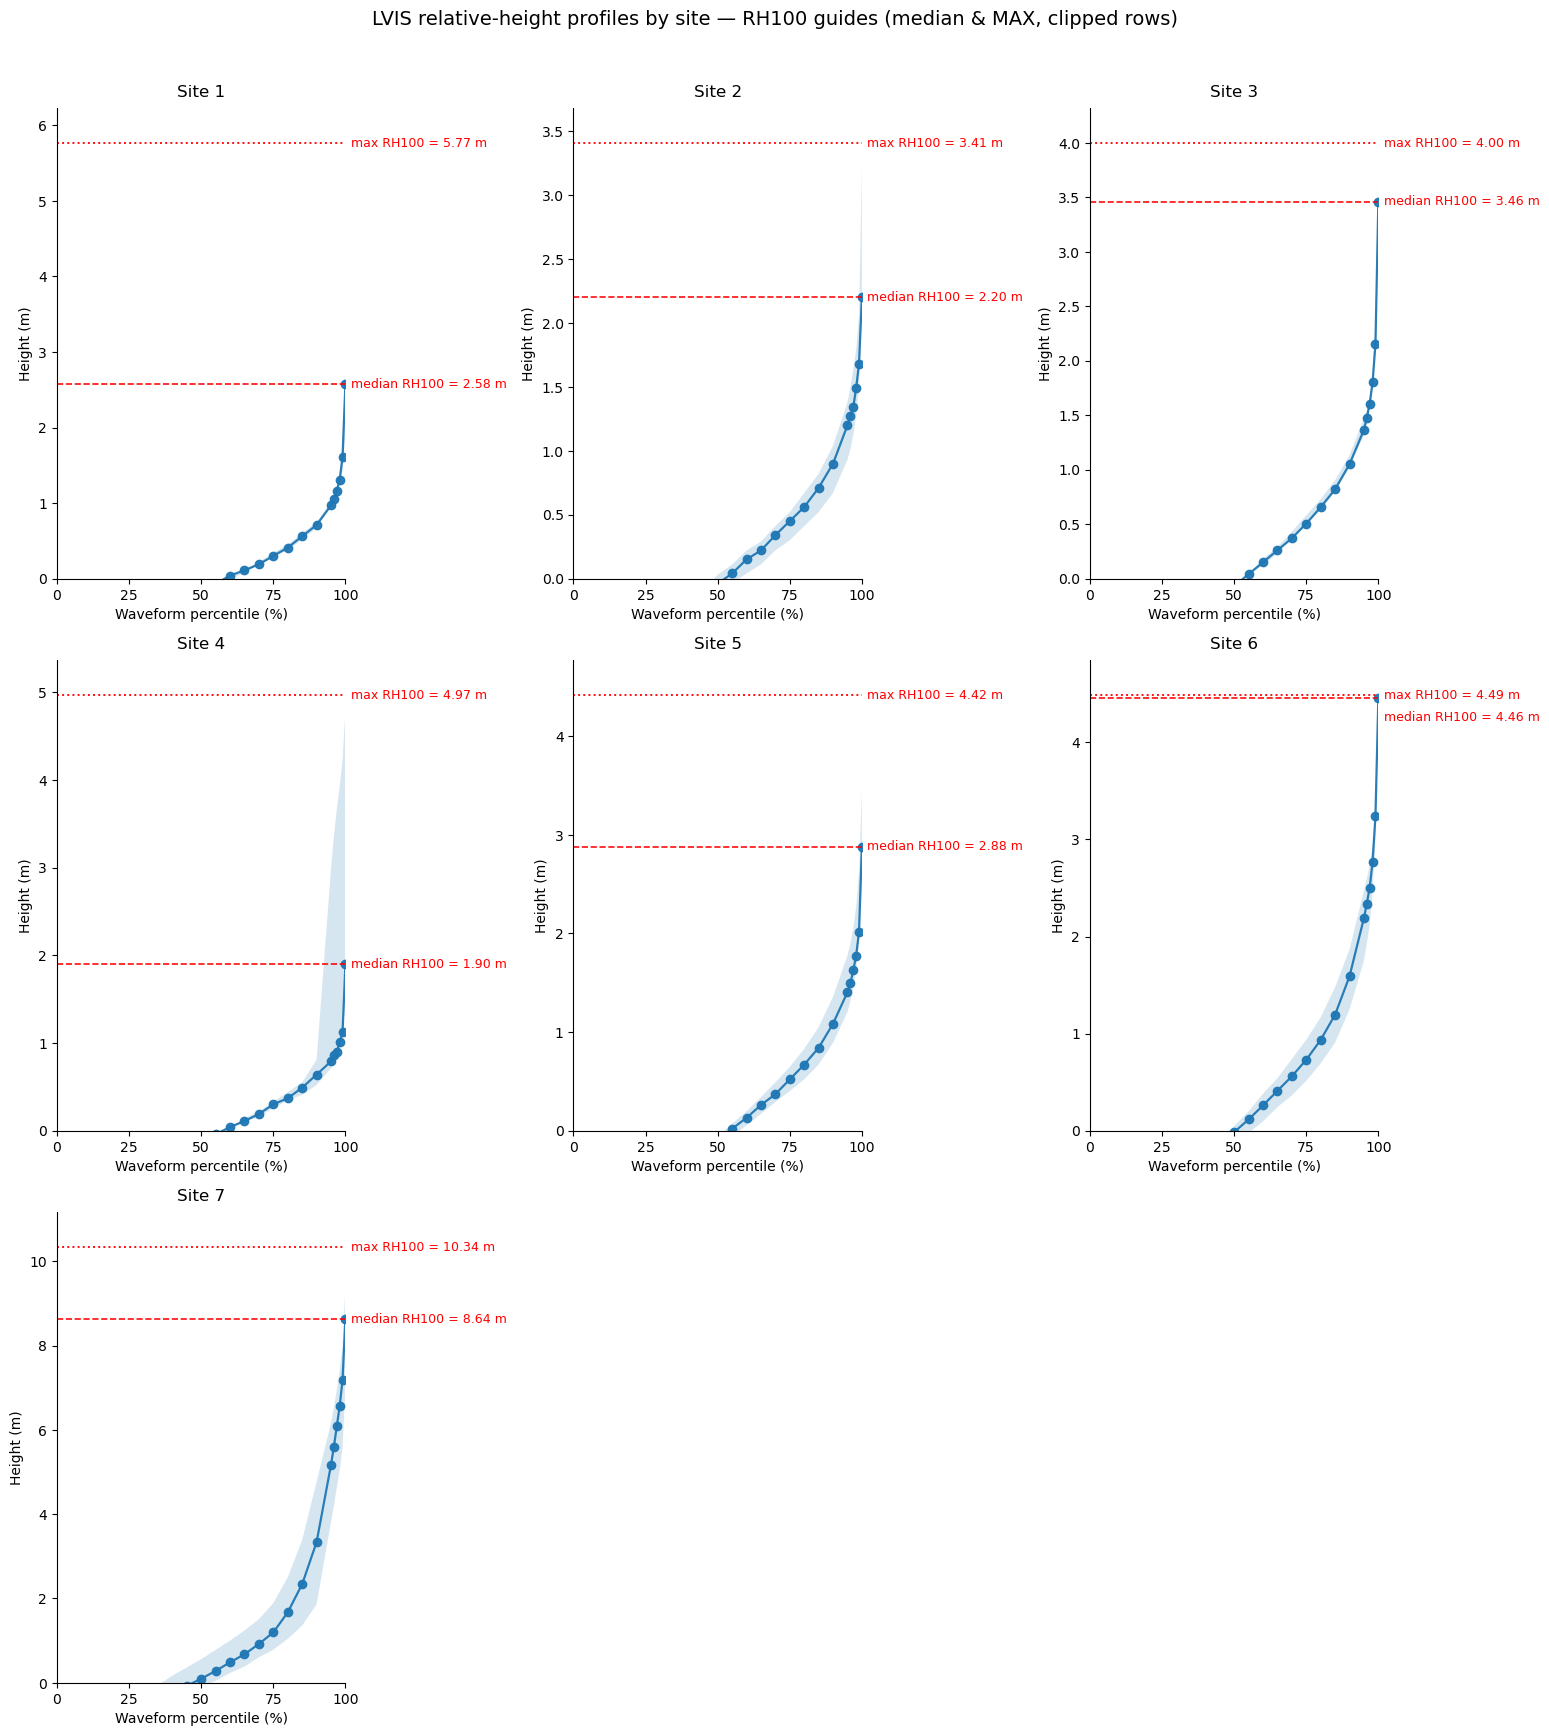

In [17]:
# RH profiles by site — robust site labelling, fixed x-ticks, anti-overlap labels
import os, re
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from math import ceil

out_dir = "data/outputs/figures3"
os.makedirs(out_dir, exist_ok=True)

# Inputs & CRS
base  = lvis_l2a_gdf.copy()
polys = sites_web if 'sites_web' in globals() else buf_web
base  = base.drop(columns=["index_left","index_right"], errors="ignore").reset_index(drop=True)
polys = polys.drop(columns=["index_left","index_right"], errors="ignore").reset_index(drop=True)

if base.crs is None:
    raise ValueError("lvis_l2a_gdf has no CRS.")
if polys.crs != base.crs:
    polys = polys.to_crs(base.crs)

# Decide which polygon column labels sites; if none, create one
cand = [c for c in polys.columns if c.lower() in {"site","site_id","plot","plot_id","id","name"}]
site_field = cand[0] if cand else "site"
if site_field not in polys.columns:
    polys[site_field] = np.arange(1, len(polys)+1)

# Keep a copy of polygon labels keyed by their index (for the fallback via index_right)
poly_labels = polys.reset_index()[["index", site_field]].set_index("index")[site_field]

# Spatial join (within)
clipped = gpd.sjoin(
    base,
    polys[[site_field,"geometry"]].rename(columns={site_field:"site"}),
    predicate="within",
    how="inner",
    lsuffix="pt",
    rsuffix="poly"
)

# Canonicalise a 'site' column robustly BEFORE dropping anything
if "site" not in clipped.columns:
    if "site_poly" in clipped.columns:
        clipped["site"] = clipped["site_poly"]
    elif "index_right" in clipped.columns:
        # Map polygon index to its label
        clipped["site"] = clipped["index_right"].map(poly_labels)
    else:
        # last resort: make a sequential label per polygon index seen
        if "index_right" not in clipped.columns:
            clipped = clipped.reset_index(names="index_right")
        codes = clipped["index_right"].astype("category").cat.codes + 1
        clipped["site"] = codes

# Now drop sjoin by-products
clipped = clipped.drop(columns=["site_poly","index_left","index_right"], errors="ignore")

# Clean site labels (avoid "Site Site1")
def clean_site_label(x):
    s = str(x).strip()
    s = re.sub(r"^\s*site\s*", "", s, flags=re.IGNORECASE)
    try:
        return int(float(s))
    except Exception:
        return s

clipped["site_clean"] = clipped["site"].apply(clean_site_label)

# RH columns & profile matrix
import re as _re
rh_cols = sorted([c for c in clipped.columns if _re.fullmatch(r"RH\d+", c)],
                 key=lambda x: int(x[2:]))
if len(rh_cols) < 3:
    raise RuntimeError(f"Need multiple RH columns; found {rh_cols}. Use the full LVIS table, not an RH100-only export.")

def profile_matrix(df_site):
    M = df_site[rh_cols].T.copy()
    M.index = M.index.str.replace("RH","", regex=False).astype(int)
    M.sort_index(inplace=True)
    return M

# Plot: one panel per site; guides at RH100 (median dashed, MAX dotted)
sites = sorted(pd.unique(clipped["site_clean"]), key=lambda x: (isinstance(x,str), x))
n_cols, n_rows = 3, ceil(len(sites)/3)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5.2, n_rows*5.8), squeeze=False)
axes = axes.ravel()

for ax in axes:
    ax.grid(False)
    for s in ("top","right"):
        ax.spines[s].set_visible(False)

for i, s in enumerate(sites):
    ax  = axes[i]
    sub = clipped.loc[clipped["site_clean"] == s]
    if sub.empty:
        ax.set_visible(False); continue

    M   = profile_matrix(sub)
    q1  = M.quantile(0.25, axis=1)
    med = M.quantile(0.50, axis=1)
    q3  = M.quantile(0.75, axis=1)

    top_pct = 100 if 100 in M.index else int(M.index.max())
    med_top = float(med.loc[top_pct])
    max_top = float(M.loc[top_pct].max())

    # Curve + ribbon
    ax.plot(M.index, med, marker="o", lw=1.6, alpha=0.95)
    ax.fill_between(M.index, q1, q3, alpha=0.18)

    # Per-site y-scale and guides
    y_top = max(max_top, med_top, float(q3.max())) * 1.08
    ax.set_ylim(0.0, y_top)
    ax.axhline(med_top, ls="--", lw=1.2, color="red", alpha=0.95)
    ax.axhline(max_top, ls=":",  lw=1.4, color="red", alpha=0.95)

    # Anti-overlap: nudge lower label if lines are very close
    y_rng = y_top if y_top > 0 else 1.0
    med_y, max_y = med_top, max_top
    if abs(max_top - med_top) < 0.06 * y_rng:
        if med_top <= max_top:
            med_y = med_top - 0.04 * y_rng
        else:
            max_y = max_top - 0.04 * y_rng

    ax.text(100.5, med_y, f" median RH{top_pct} = {med_top:.2f} m",
            va="center", ha="left", fontsize=9, color="red")
    ax.text(100.5, max_y, f" max RH{top_pct} = {max_top:.2f} m",
            va="center", ha="left", fontsize=9, color="red")

    # Axes cosmetics
    ax.set_title(f"Site {s}", pad=8)
    ax.set_xlabel("Waveform percentile (%)")
    ax.set_ylabel("Height (m)")
    ax.set_xlim(0, 100)
    ax.set_xticks([0, 25, 50, 75, 100])

# Hide unused panels
for j in range(i+1, n_rows*n_cols):
    axes[j].set_visible(False)

fig.suptitle("LVIS relative-height profiles by site — RH100 guides (median & MAX, clipped rows)",
             y=0.995, fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98])

In [18]:
# Save
import os

out_dir = "data/outputs/figures3"
os.makedirs(out_dir, exist_ok=True)

fname_base = "lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL"
png_path = os.path.abspath(os.path.join(out_dir, f"{fname_base}.png"))
pdf_path = os.path.abspath(os.path.join(out_dir, f"{fname_base}.pdf"))

fig.tight_layout(rect=[0, 0, 1, 0.98])
fig.savefig(png_path, dpi=300, bbox_inches="tight")
fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
print("Wrote:", png_path)
print("Wrote:", pdf_path)

plt.close(fig)

Wrote: /home/prutlokoane/data/outputs/figures3/lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL.png
Wrote: /home/prutlokoane/data/outputs/figures3/lvis_profiles_by_site_rh100_guides_CLIPPED_fixed_xticks_FINAL.pdf


### Convert Earthaccess granules to a GeoPackage with polygons (EPSG:4326)

In [22]:
# Convert the list to a GeoDataFrame
gdf = convert_list_gdf(l2_poly)

# Save to GeoPackage
out_gpkg = "data/outputs/lvis_granules.gpkg"
gdf.to_file(out_gpkg, layer="lvis_granules", driver="GPKG")

print(f"Wrote: {out_gpkg} (layer: lvis_granules)")

Wrote: data/outputs/lvis_granules.gpkg (layer: lvis_granules)


### Convert RH100 footprints to a GeoPackage with points

In [24]:
# Project to UTM for buffering (as in your code)
pts_utm_all = lvis_l2a_gdf[["RH100", "geometry"]].dropna(subset=["RH100"]).to_crs(utm_epsg)

# Make footprint circles (full set, not clipped)
footprints_all = pts_utm_all.copy()
footprints_all["geometry"] = footprints_all.geometry.buffer(foot_radius_m)  # 25m circles

# Reproject back to WGS84 if desired
footprints_all_web = footprints_all.to_crs(4326)

# Save to GeoPackage
footprints_all_web.to_file("data/outputs/lvis_rh100_footprints_all.gpkg", layer="rh100_footprints_all", driver="GPKG")

### Convert the clipped RH100 footprints to a GeoPackage with Points

In [25]:
# Save to GeoPackage
buf_web.to_file("data/outputs/lvis_rh100_footprints_clipped.gpkg", layer="rh100_footprints_clipped", driver="GPKG")

### Convert the clipped RH100 Points to a GeoPackage

In [26]:
# Save to GeoPackage
pts_web.to_file("data/outputs/lvis_rh100_points_clipped.gpkg", layer="rh100_points_clipped", driver="GPKG")

### Download every file in lvis_f list to working directory

In [28]:
import s3fs

fs = s3fs.S3FileSystem(anon=False)

for s3_url in lvis_f:
    local_fn = s3_url.split('/')[-1]
    fs.get(s3_url, local_fn)

**The files were saved on the set directory, I moved all the files into the directory: `data/LVIS`**

In [8]:
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon

granule_files = [
    "data/LVIS/LVISF2_BioSCape2023_1028_R2404_050431.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1028_R2404_051113.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1028_R2404_051210.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1028_R2404_052128.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_036051.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_037033.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_037808.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_038739.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_039532.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_039619.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_040572.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_041386.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1029_R2404_044604.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1113_R2404_034819.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1113_R2404_039291.TXT",
    "data/LVIS/LVISF2_BioSCape2023_1113_R2404_039379.TXT"
]

def extract_header_line(path):
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        header_lines = [ln for ln in f if ln.lstrip().startswith("#")]
    if not header_lines:
        raise ValueError(f"No commented header lines in {path}")
    cols = header_lines[-1].lstrip("#").strip().split()
    return cols

def load_lvis_ascii(path):
    cols = extract_header_line(path)
    # Pandas deprecation: use regex sep for whitespace
    return pd.read_csv(path, sep=r"\s+", comment="#", names=cols, header=None, engine="python")

out_dir = "data/LVIS/gpkg"
os.makedirs(out_dir, exist_ok=True)

for fp in granule_files:
    df = load_lvis_ascii(fp)
    needed = {"GLON", "GLAT", "SHOTNUMBER"}
    if not needed.issubset(df.columns):
        raise KeyError(f"{os.path.basename(fp)} missing {needed - set(df.columns)}")

    # Optional derived fields — uncomment if useful
    # if {"RH100", "ZG"}.issubset(df.columns):
    #     df["CANOPY_HT"] = df["RH100"] - df["ZG"]

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["GLON"], df["GLAT"]), crs="EPSG:4326")
    out_path = os.path.join(out_dir, os.path.basename(fp).replace(".TXT", ".gpkg"))
    gdf.to_file(out_path, driver="GPKG")
    print(f"Saved {len(gdf)} shots → {out_path}")

Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1028_R2404_050431.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1028_R2404_051113.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1028_R2404_051210.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1028_R2404_052128.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_036051.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_037033.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_037808.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_038739.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_039532.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_039619.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_040572.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2023_1029_R2404_041386.gpkg
Saved 350000 shots → data/LVIS/gpkg/LVISF2_BioSCape2

## Comparisons

In [3]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from math import sqrt

### Load and prepare data

In [5]:
XLSX = "data/Comparisons/Site RH.xlsx"  # Excel Sheet
df = pd.read_excel(XLSX)
df["Site"] = df["Site"].ffill()  # carry site labels down
x_col = "Measured Silvertree Height (m)"
y_col = "LVIS Relative Height (m)"

In [6]:
# All paired rows
pairs = df.dropna(subset=[x_col, y_col]).copy()

# Per-plot maxima
max_meas = df.groupby("Site")[x_col].max()
max_lvis = df.groupby("Site")[y_col].max()
max_df   = pd.DataFrame({"Site": max_meas.index,
                         "meas": max_meas.values,
                         "lvis": max_lvis.values})

### Configure functions

In [8]:
def metrics(y_true, y_pred):
    err = np.asarray(y_pred) - np.asarray(y_true)
    mae = np.mean(np.abs(err))
    rmse = sqrt(np.mean(err**2))
    return mae, rmse

def fit_and_annotate(ax, x, y, xy_units=True):
    # Least squares
    lr = linregress(x, y)           # slope, intercept, rvalue, pvalue, stderr
    yhat = lr.slope * np.asarray(x) + lr.intercept
    r2   = lr.rvalue**2
    mae, rmse = metrics(x, y)       # compare LiDAR to field in the same panel

    # 1:1 line (grey dashed)
    lim = [min(np.min(x), np.min(y)) - 0.3, max(np.max(x), np.max(y)) + 0.3]
    ax.plot(lim, lim, ls="--", lw=1.2, color="0.5", zorder=1)
    # fitted line (red)
    xx = np.linspace(*lim, 100)
    ax.plot(xx, lr.slope*xx + lr.intercept, color="red", lw=1.6, zorder=2)

    # Cosmetics
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel("Field-measured Silvertree height (m)")
    ax.set_ylabel("LVIS RH100 (m)")
    ax.set_aspect("equal", adjustable="box")

    # Stats box (top-left)
    txt = (f"N = {len(x)}\n"
           f"b (slope) = {lr.slope:.3f}\n"
           f"a (intercept) = {lr.intercept:.3f} m\n"
           f"R² = {r2:.3f}\n"
           f"MAE = {mae:.2f} m\n"
           f"RMSE = {rmse:.2f} m\n"
           f"p = {lr.pvalue:.3g}")
    ax.text(0.03, 0.97, txt, va="top", ha="left",
            transform=ax.transAxes, fontsize=9,
            bbox=dict(facecolor="white", edgecolor="0.25", alpha=0.9, boxstyle="round,pad=0.4"))
    return lr

def ring_scatter(ax, x, y, site, palette=None, size=48, lw=1.3):
    # Unfilled circular markers coloured by site (edge only)
    sites = pd.unique(site)
    if palette is None:
        # Deterministic palette across runs
        base = plt.cm.Set2(np.linspace(0, 1, max(8, len(sites))))
        palette = {s: base[i % len(base)] for i, s in enumerate(sorted(sites))}
    for s in sorted(sites, key=lambda z: (str(z))):
        mask = site == s
        ax.scatter(x[mask], y[mask],
                   s=size, marker="o",
                   facecolors="none",
                   edgecolors=palette[s], linewidths=lw,
                   label=str(s), zorder=3)
    return palette

### Plot the figures

Text(0.5, 1.02, '(b) Plot maxima')

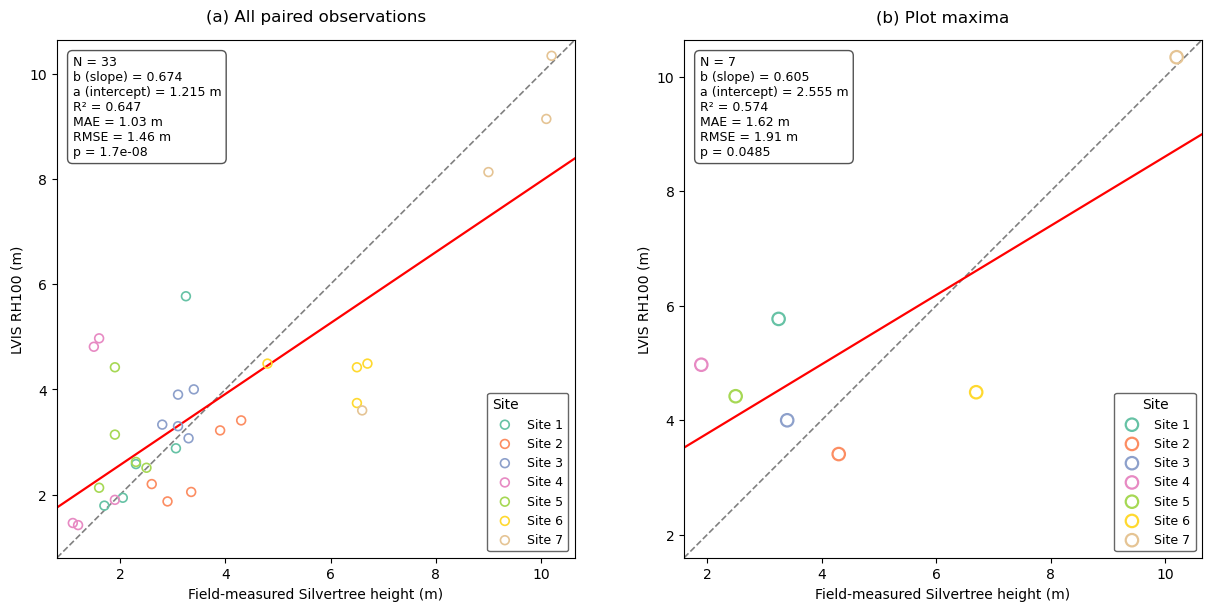

In [9]:
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12.5, 6.0), constrained_layout=True)

# Panel A: all paired obs by site (rings)
palette = ring_scatter(axA,
                       pairs[x_col].values,
                       pairs[y_col].values,
                       pairs["Site"].values,
                       size=40, lw=1.2)
fit_and_annotate(axA, pairs[x_col].values, pairs[y_col].values)
axA.set_title("(a) All paired observations", y=1.02)
# Legend (categorical sites)
leg = axA.legend(title="Site", loc="lower right", frameon=True, fontsize=9,
                 facecolor="white", edgecolor="0.25")
leg._legend_box.align = "left"

# Panel B: per-plot maxima (rings, one per site)
# use the same colours for consistency
for _, r in max_df.iterrows():
    axB.scatter(r["meas"], r["lvis"],
                s=80, marker="o", facecolors="none",
                edgecolors=palette.get(r["Site"], "k"), linewidths=1.6,
                label=str(r["Site"]), zorder=3)
# Collapse duplicate labels in legend by overwriting handles
handles, labels = axB.get_legend_handles_labels()
dedup = dict(zip(labels, handles))
axB.legend(dedup.values(), dedup.keys(), title="Site", loc="lower right",
           frameon=True, fontsize=9, facecolor="white", edgecolor="0.25")
fit_and_annotate(axB, max_df["meas"].values, max_df["lvis"].values)
axB.set_title("(b) Plot maxima", y=1.02)

### Save plot

In [10]:
# Save and show
out_png = "fig_lvis_vs_field_combined_rings.png"
out_pdf = "fig_lvis_vs_field_combined_rings.pdf"
fig.savefig(out_png, dpi=300, bbox_inches="tight")
fig.savefig(out_pdf, dpi=300, bbox_inches="tight")
plt.show()

print("Wrote:", out_png, "and", out_pdf)

Wrote: fig_lvis_vs_field_combined_rings.png and fig_lvis_vs_field_combined_rings.pdf


### Plot more saturated graphs (Better visualisations)

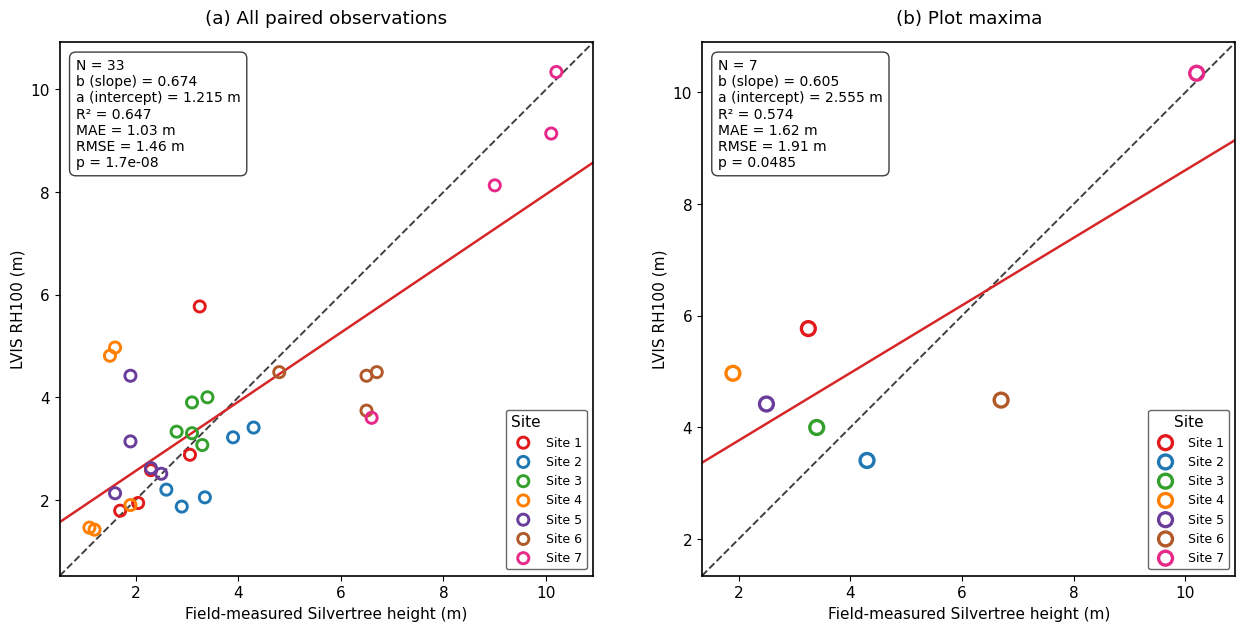

Wrote: fig_lvis_vs_field_combined_rings_SAT.png and fig_lvis_vs_field_combined_rings_SAT.pdf


In [2]:
import os, numpy as np, pandas as pd, matplotlib as mpl, matplotlib.pyplot as plt
from scipy.stats import linregress
from math import sqrt

# Display & export defaults
mpl.rcParams.update({
    "font.size": 11,
    "axes.linewidth": 1.2,
    "savefig.dpi": 300,
    "savefig.facecolor": "white",
    "figure.constrained_layout.use": True,
})

# Load & prepare
XLSX = "data/Comparisons/Site RH.xlsx"  # adjust if needed
df = pd.read_excel(XLSX)
df["Site"] = df["Site"].ffill()  # carry down site labels

x_col = "Measured Silvertree Height (m)"
y_col = "LVIS Relative Height (m)"

pairs = df.dropna(subset=[x_col, y_col]).copy()

max_meas = df.groupby("Site")[x_col].max()
max_lvis = df.groupby("Site")[y_col].max()
max_df   = pd.DataFrame({"Site": max_meas.index,
                         "meas": max_meas.values,
                         "lvis": max_lvis.values})

# Colour palette (vibrant, high-contrast)
# Seven strong hues (mostly ColorBrewer Set1-style)
vibrant_hex = [
    "#e31a1c",  # red
    "#1f78b4",  # blue
    "#33a02c",  # green
    "#ff7f00",  # orange
    "#6a3d9a",  # purple
    "#b15928",  # brown
    "#e7298a",  # magenta
    "#17becf",  # cyan (spare)
]

sites_sorted = sorted(pd.unique(df["Site"].dropna()), key=str)
palette = {s: vibrant_hex[i % len(vibrant_hex)] for i, s in enumerate(sites_sorted)}

# Helpers
def metrics(y_true, y_pred):
    err = np.asarray(y_pred) - np.asarray(y_true)
    mae = np.mean(np.abs(err))
    rmse = sqrt(np.mean(err**2))
    return mae, rmse

def fit_and_annotate(ax, x, y):
    lr = linregress(x, y)           # slope, intercept, r, p, stderr
    r2 = lr.rvalue**2
    mae, rmse = metrics(x, y)

    # Axis limits padded a touch
    lo = min(np.min(x), np.min(y))
    hi = max(np.max(x), np.max(y))
    pad = 0.3 + 0.03*(hi - lo)
    lim = [lo - pad, hi + pad]

    # 1:1 line (dark grey dashed) and fitted line (red)
    ax.plot(lim, lim, ls="--", lw=1.4, color="0.25", zorder=1)
    xx = np.linspace(*lim, 200)
    ax.plot(xx, lr.slope*xx + lr.intercept, color="#d62728", lw=1.8, zorder=2)

    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("Field-measured Silvertree height (m)")
    ax.set_ylabel("LVIS RH100 (m)")

    # On-panel stats
    txt = (f"N = {len(x)}\n"
           f"b (slope) = {lr.slope:.3f}\n"
           f"a (intercept) = {lr.intercept:.3f} m\n"
           f"R² = {r2:.3f}\n"
           f"MAE = {mae:.2f} m\n"
           f"RMSE = {rmse:.2f} m\n"
           f"p = {lr.pvalue:.3g}")
    ax.text(0.03, 0.97, txt, va="top", ha="left",
            transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor="white", edgecolor="0.2",
                      alpha=0.95, boxstyle="round,pad=0.45"))
    return lr

def ring_scatter(ax, x, y, site,
                 size=70, lw=2.2, palette=palette):
    # Unfilled rings with saturated edge colours by site
    for s in sorted(pd.unique(site), key=str):
        m = (site == s)
        ax.scatter(np.asarray(x)[m], np.asarray(y)[m],
                   s=size, marker="o", facecolors="none",
                   edgecolors=palette[s], linewidths=lw, zorder=3,
                   label=str(s))

# Combined figure: (a) all pairs, (b) per-plot maxima
fig, (axA, axB) = plt.subplots(1, 2, figsize=(12.8, 6.2))

# Panel (a): all paired observations
ring_scatter(axA, pairs[x_col].values, pairs[y_col].values, pairs["Site"].values,
             size=64, lw=2.1, palette=palette)
fit_and_annotate(axA, pairs[x_col].values, pairs[y_col].values)
axA.set_title("(a) All paired observations", y=1.02)
legA = axA.legend(title="Site", loc="lower right", frameon=True, fontsize=9,
                  facecolor="white", edgecolor="0.25")
legA._legend_box.align = "left"

# Panel (b): per-plot maxima (one ring per site, matching colours)
for _, r in max_df.iterrows():
    axB.scatter(r["meas"], r["lvis"], s=100, marker="o",
                facecolors="none", edgecolors=palette[r["Site"]],
                linewidths=2.4, zorder=3, label=str(r["Site"]))
# De-duplicate legend entries
h, lb = axB.get_legend_handles_labels()
dedup = dict(zip(lb, h))
axB.legend(dedup.values(), dedup.keys(), title="Site",
           loc="lower right", frameon=True, fontsize=9,
           facecolor="white", edgecolor="0.25")
fit_and_annotate(axB, max_df["meas"].values, max_df["lvis"].values)
axB.set_title("(b) Plot maxima", y=1.02)

# Save + show
out_png = "fig_lvis_vs_field_combined_rings_SAT.png"
out_pdf = "fig_lvis_vs_field_combined_rings_SAT.pdf"
fig.savefig(out_png, bbox_inches="tight")
fig.savefig(out_pdf, bbox_inches="tight")
plt.show()

print("Wrote:", out_png, "and", out_pdf)